In [24]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble, IBMQ
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA, ADAM
from qiskit.tools.monitor import job_monitor
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult

COUNTER = 0
DIR_val_train = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/amp_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/amp_enc_data_set_test_classes.csv"

#IBMQ.save_account("07916ec631273d08971f67f1267677801b440be43215767571a165abe0ac621415a17cc5a357e2e2fffa511a6fd3748eb0c46d35ca79d8752b97788fd71f390a", overwrite=True)
#IBMQ.load_account()

# Circuito

In [43]:
n_qubits = 4

encoding = RawFeatureVector(16)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=2, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")
qc = encoding.compose(ansatz)
qc.measure_all()

In [44]:
def get_encode(file, type_ENC):

    """
    Funcao responsavel pelo encoding (amplitude)
    """
    if type_ENC.lower() == "amplitude":

        data_ENC = np.genfromtxt(file, delimiter=";")

    else:
        return None

    return data_ENC

In [45]:
train_data = get_encode(DIR_val_train, "amplitude")
train_labels = np.genfromtxt(DIR_cls_train, delimiter=";")

test_data = get_encode(DIR_val_test, "amplitude")
test_labels = np.genfromtxt(DIR_cls_test, delimiter=";")

In [46]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [47]:
def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [48]:
train_labels_oh = train_labels
test_labels_oh = test_labels

In [49]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):

    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()
    

    predictions = [classification(results.get_counts(c)) for c in circuits]
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [50]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        exp_val += ((-1)**(count_ones(state)%2))*prob

    if label:
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    return (y-y_hat)*(y-y_hat)

In [51]:
opt_var1, opt_value1 , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True, initial_point=None)

Cost 2.05
Cost 1.6
Cost 2.5
Cost 1.05
Cost 2.5
Cost 0.85
Cost 1.55
Cost 1.9
Cost 2.0
Cost 0.85
Cost 1.55
Cost 1.25
Cost 0.95
Cost 1.6
Cost 2.5
Cost 0.85
Cost 1.5
Cost 1.45
Cost 1.6
Cost 0.95
Cost 1.7
Cost 1.05
Cost 2.5
Cost 0.5
Cost 1.25
Cost 0.65
Cost 0.95
Cost 0.5
Cost 0.65
Cost 1.45
Cost 2.5
Cost 1.25
Cost 1.7
Cost 0.55
Cost 0.5
Cost 1.25
Cost 2.35
Cost 0.75
Cost 0.85
Cost 1.1
Cost 1.4
Cost 1.25
Cost 0.55
Cost 2.4
Cost 0.6
Cost 2.5
Cost 1.1
Cost 1.75
Cost 1.1
Cost 2.05
Cost 1.4
Cost 2.15
Cost 2.0
Cost 2.5
Cost 1.1
Cost 1.55
Cost 1.15
Cost 2.4
Cost 0.75
Cost 1.75
Cost 0.5
Cost 0.65
Cost 0.5
Cost 1.0
Cost 0.55
Cost 2.25
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.55
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.65
Cost 0.5
Cost 0.5
Cost 0.75
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.55
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.5
Cost 0.

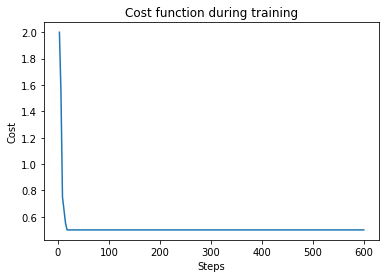

In [52]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("Cost function during training")
plt.show()

In [56]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()
    
    prediction = [classification(results.get_counts(c)) for c in circuits]
    accuracy = 0
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [57]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var1, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

Test set accuracy - 0.5


In [58]:
print(opt_value1)
print(opt_var1)

0.5
[ 0.06967529 -0.39699535  1.79961001 -0.39583495 -0.27823976  2.05730073
 -0.97130105  1.81355633  1.40088189  1.39611148  0.75347299 -0.43639247
  0.78448569  1.08909504 -0.05791567 -0.19519581  0.5927774  -1.56505878
  1.30160472  0.75134841 -0.87476424  0.00922751  1.5753815   0.09413834]


## Cross Entropy Loss

### Parity method

In [59]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [60]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    return probs

def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    return np.sum(y*np.log(y_hat))

In [61]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]
    
    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [ ]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True, initial_point=opt_var)

Cost: 0.5006994476328066
Cost: 0.5219393879401611
Cost: 0.5212340852769056
Cost: 0.5117045200727761
Cost: 0.5093495309235063
Cost: 0.49453194005338175
Cost: 0.5051164581784323
Cost: 0.5048125549449753
Cost: 0.5091401472908463
Cost: 0.516128253704316
Cost: 0.5137152306681465
Cost: 0.5263761224835468
Cost: 0.49816147667043964
Cost: 0.506485089962079
Cost: 0.5052336397868903
Cost: 0.505598570781977
Cost: 0.5085174593897368
Cost: 0.4964235276191582
Cost: 0.5148091453870842
Cost: 0.5175403810613604
Cost: 0.5413082087623262
Cost: 0.5033000130909194
Cost: 0.5364394493566711
Cost: 0.5148695946320506
Cost: 0.5157783953828191
Cost: 0.5281458568099117
Cost: 0.5177065709884788
Cost: 0.5097865349807407
Cost: 0.49929101873492404
Cost: 0.5020563401227193
Cost: 0.508095282506957
Cost: 0.5123295475482156
Cost: 0.5060793150976641
Cost: 0.5156088805391834
Cost: 0.5445568214543878
Cost: 0.5111573484334151
Cost: 0.5089617296752691
Cost: 0.5178747724439434
Cost: 0.49715864900223095
Cost: 0.5033400002145483


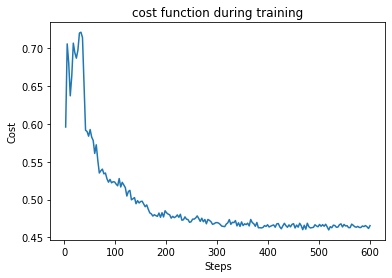

In [67]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [72]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [73]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

Test set accuracy - 0.3333333333333333


In [42]:
print(len(train_data))

80
